In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Configuration
data_dir = '../../dataset/train-curat-dataset'

In [3]:
model_name = 'vgg16' 
num_classes = 7
batch_size = 16
num_epochs = 200
feature_extract = True
 
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
 
    val_acc_history = []
    train_acc_history = []
 
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
 
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
 
            running_loss = 0.0
            running_corrects = 0
 
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Zero the parameter gradients
                optimizer.zero_grad()
 
                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
 
                    _, preds = torch.max(outputs, 1)
 
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
 
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
 
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
 
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
 #initilize the vgg16 model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
 
    if model_name == "vgg16":
        """ VGG16
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
 
    else:
        print("Invalid model name, exiting...")
        exit()
 
    return model_ft, input_size

In [9]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
 
# Print the model architecture
#print(model_ft)

# Send the model to GPU
model_ft = model_ft.to(device)

/home/user/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
'''
Gather the parameters to be optimized/updated in this run. If we are
fine-tuning we will be updating all parameters. However, if we are
doing feature extract method, we will only update the parameters
that we have just initialized, i.e. the parameters with requires_grad
is True
'''
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)
 
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
 
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [16]:
###, is_inception=(model_name=="inception") igone this
# Train and evaluate
model_ft, train_acc_hist, val_acc_hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)
 

Epoch 0/199
----------
train Loss: 1.3224 Acc: 0.5714
val Loss: 0.9374 Acc: 0.7364
Epoch 1/199
----------
train Loss: 0.8912 Acc: 0.7290
val Loss: 0.7550 Acc: 0.7894
Epoch 2/199
----------
train Loss: 0.7767 Acc: 0.7563
val Loss: 0.6793 Acc: 0.7970
Epoch 3/199
----------
train Loss: 0.7167 Acc: 0.7714
val Loss: 0.6380 Acc: 0.8083
Epoch 4/199
----------
train Loss: 0.6872 Acc: 0.7811
val Loss: 0.6053 Acc: 0.8159
Epoch 5/199
----------
train Loss: 0.6583 Acc: 0.7790
val Loss: 0.5823 Acc: 0.8209
Epoch 6/199
----------
train Loss: 0.6287 Acc: 0.7929
val Loss: 0.5613 Acc: 0.8247
Epoch 7/199
----------
train Loss: 0.6182 Acc: 0.7924
val Loss: 0.5502 Acc: 0.8398
Epoch 8/199
----------
train Loss: 0.6019 Acc: 0.7992
val Loss: 0.5381 Acc: 0.8285
Epoch 9/199
----------
train Loss: 0.5755 Acc: 0.8126
val Loss: 0.5267 Acc: 0.8310
Epoch 10/199
----------
train Loss: 0.5721 Acc: 0.8092
val Loss: 0.5157 Acc: 0.8335
Epoch 11/199
----------
train Loss: 0.5588 Acc: 0.8143
val Loss: 0.5096 Acc: 0.8386
Ep

In [17]:
# Save the best model weights
torch.save(model_ft.state_dict(), 'building_orig_vgg_weights.pth')

In [18]:
train_acc_hist = torch.tensor(train_acc_hist)
val_acc_hist = torch.tensor(val_acc_hist)

train_acc_hist = train_acc_hist.cpu()
val_acc_hist = val_acc_hist.cpu()

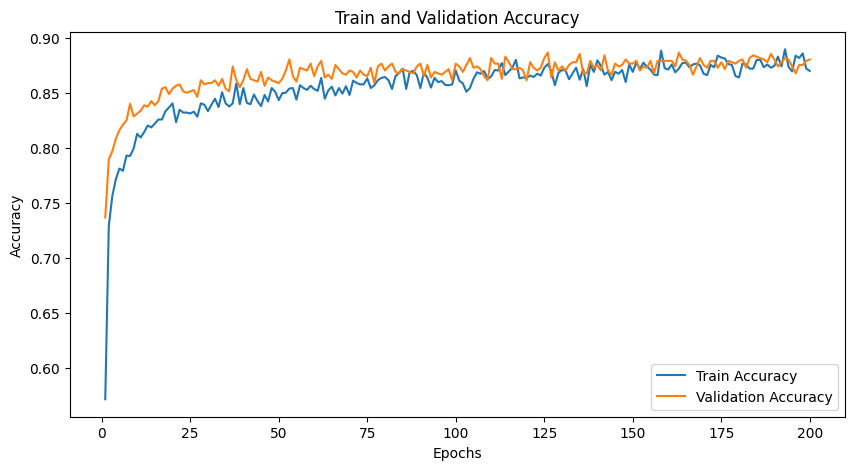

In [19]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.title("Train and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1, num_epochs+1), train_acc_hist, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_acc_hist, label="Validation Accuracy")
plt.legend()
plt.show()
 

In [24]:
# Evaluate the model on test data
model_ft.eval()
test_corrects = 0
all_preds = []
all_labels = []
 
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
 
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
 
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    test_corrects += torch.sum(preds == labels.data)
 
test_acc = test_corrects.double() / dataset_sizes['test']
print('Test Accuracy: {:.4f}'.format(test_acc))
 
# Generate confusion matrix and classification report
conf_mat = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Test Accuracy: 0.8359
Confusion Matrix:
 [[109   2   4   4   0   4   1]
 [  1  86  23   1   1   4   0]
 [  0  10 109   0   2   0   3]
 [  1   5   4  82   0   3   9]
 [  0   2   1   0 116   0   1]
 [  2   2   3   7   0  78   8]
 [  1   1   8   5   6   1  82]]
Classification Report:
               precision    recall  f1-score   support

       algae       0.96      0.88      0.92       124
 major_crack       0.80      0.74      0.77       116
 minor_crack       0.72      0.88      0.79       124
     peeling       0.83      0.79      0.81       104
       plain       0.93      0.97      0.95       120
    spalling       0.87      0.78      0.82       100
       stain       0.79      0.79      0.79       104

    accuracy                           0.84       792
   macro avg       0.84      0.83      0.83       792
weighted avg       0.84      0.84      0.84       792



In [28]:
import pandas as pd

# Convert the labels and predictions to their corresponding class names
actual_class_names = [class_names[label] for label in all_labels]
predicted_class_names = [class_names[pred] for pred in all_preds]

# Create the DataFrame
res = pd.DataFrame({"actual": actual_class_names, "predicted": predicted_class_names})

#res = pd.DataFrame( {"actual": all_labels, "predicted": all_preds})
print(res)
res.to_csv('vgg16_curat_results.csv', index=False)

          actual    predicted
0    major_crack  major_crack
1        peeling      peeling
2          plain        plain
3        peeling  major_crack
4        peeling      peeling
..           ...          ...
787  minor_crack  major_crack
788  minor_crack  minor_crack
789        stain        stain
790  minor_crack  minor_crack
791        algae        algae

[792 rows x 2 columns]


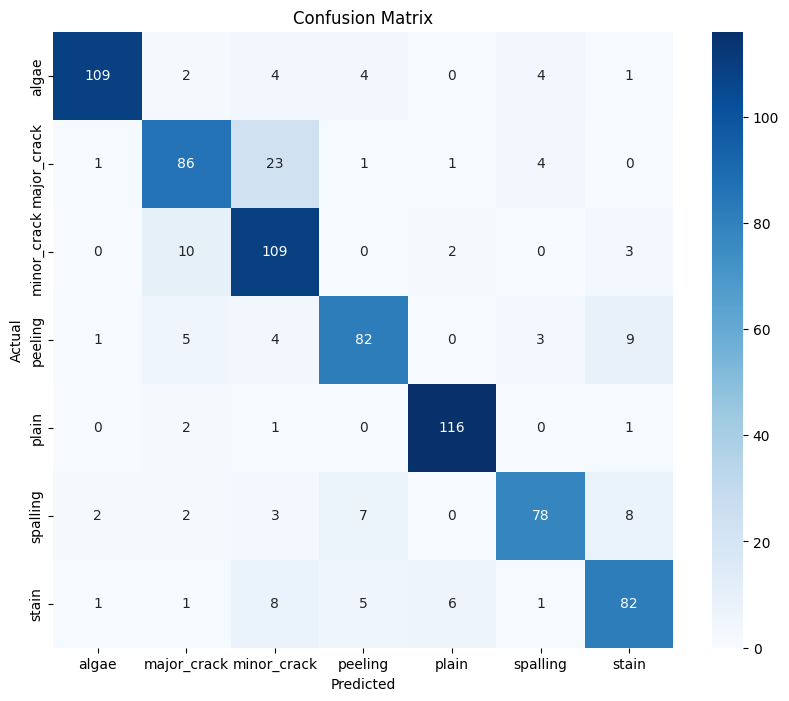

In [25]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('building_origin_vgg16_confusion_matrix.png')
plt.show()
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.37117907..1.5593902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4329139..1.6291069].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6813945].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..1.5593902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7521569..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91917115..0.39163405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1179

Accuracy: 0.8359
Precision: [0.95614035 0.7962963  0.71710526 0.82828283 0.928      0.86666667
 0.78846154]
Recall: [0.87903226 0.74137931 0.87903226 0.78846154 0.96666667 0.78
 0.78846154]
F1 Score: [0.91596639 0.76785714 0.78985507 0.80788177 0.94693878 0.82105263
 0.78846154]


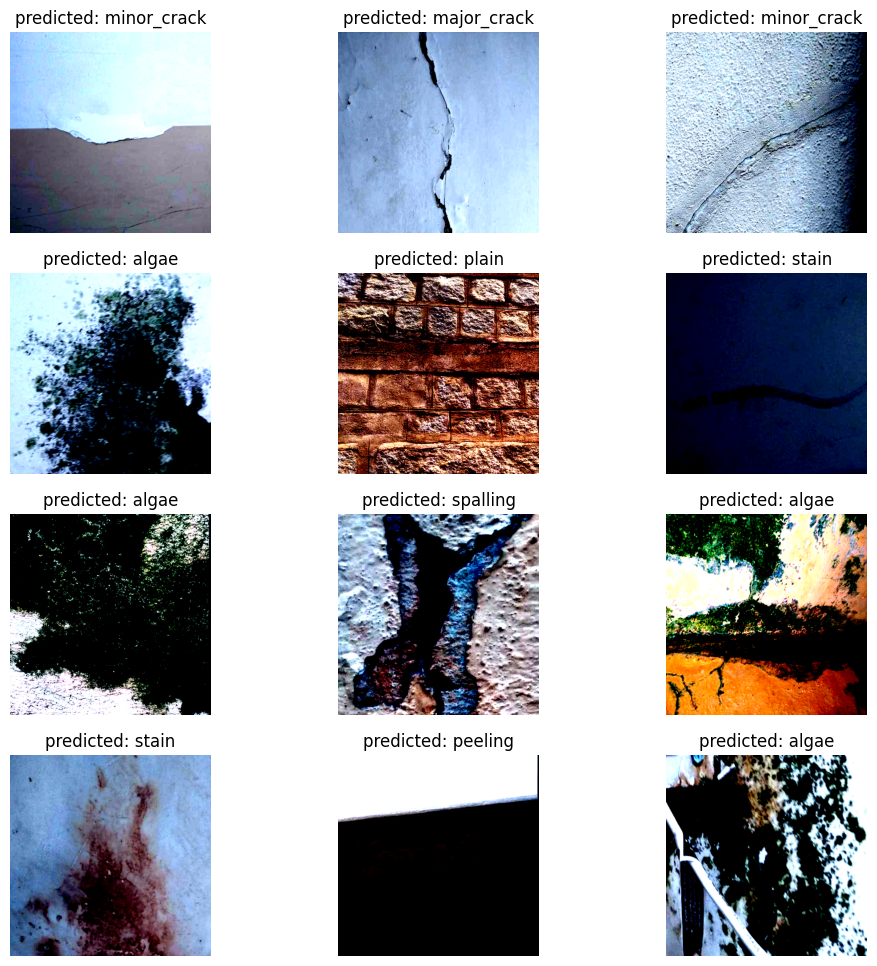

In [26]:
def visualize_model(model, dataloaders, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12))  # Increase the figure size
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(4, 3, images_so_far)  # Create a 3x3 grid of subplots
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    
    model.train(mode=was_training)


# Visualize some predictions
visualize_model(model_ft, dataloaders)
 
# Compute and display evaluation metrics
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
 
accuracy = np.mean(y_true == y_pred)
precision = np.diag(conf_mat) / np.sum(conf_mat, axis=0)
recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
f1_score = 2 * precision * recall / (precision + recall)
 
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
 
# Ensure the confusion matrix and the classification report are saved
with open('origin_vgg16_classification_report.txt', 'w') as f:
    f.write(f"Classification Report:\n{class_report}\n")